# The Stochastic Neoclassical Growth Model as a Python Object

Python allows for object-oriented programming.
This is a coding paradigm that hinges on creating your own objects.

An object in any programming language is a _thing_ that is characterized by two attributes: instance data and methods.

Consider the case of a list.
The object `list` in Python is, indeed, an object.
Any list instance is characterized by ordered, indexed elements and by a set of methods.
For example, lists allow for `list.append()` and `list.pop()` methods (there are many others).

<sup>There are also <i><a href="https://stackoverflow.com/questions/100003/">metaclasses</a></i>, but that's a topic for another time.</sup>

The goal of this notebook is to

1. Show how to create a Python object (`class`), and
1. Code the Stochastic Neoclassical Growth Model as an object.

In [1]:
from time import time
import numpy as np
import pandas as pd
from scipy import linalg as la
from scipy import interpolate as ip
from matplotlib import pyplot as plt
plt.rc('text', usetex=False)

# Do not run this outside Jupyter Notebooks
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

## A primer on Python objects

The main reference for Python classes is the [official Python reference](https://docs.python.org/3/tutorial/classes.html).

A class is an object that has two categories of attributes: instance data and methods.
One such attribute may be missing, but the gist remains.
Instance data is the data that the object is expected to handle.
In the case of a list, its elements are instance data (and yes, lists may be empty).
Methods are functions in all respects, with the exception that they are assumed to be aware of the object's instance data and are assumed to always work with it (except for user error).

An example is worth a thousand words.
Consider a line, geometrically speaking.
In Euclidean geometry over dense sets, a line is characterized by two numbers: a slope and an intercept.
In maths, a line is a function $f : X \to Y$ with $X, Y \subseteq \mathbb{R}$, such that $f(x) = mx + q$, for given $m, q \in \mathbb{R}$.
Suppose we want to turn a line into a Python object.

We declare an object with the keyword `class`, followed by the class name.
In Python, the most popular naming convention is CamelCase, which does not separate words (e.g., with underscores) and where the first letter of each word is capitalized.
The instance data of a line are the real numbers $m$ and $q$.
In fact, these numbers are all we need to characterize a line.
One method of a line can be to return the value $f(x)$ for a given $x$, provided we have knowledge of $m$ and $q$.

What follows puts the words above in code.

In [2]:
class Line:
    
    def __init__(self, m, q):
        self.slope = m
        self.intercept = q
        
    def evaluate(self, x):
        return self.slope * x + self.intercept
    
    @property
    def m(self):
        return self.slope
    
    @property
    def q(self):
        return self.intercept

We defined a line as an object in Python.
First, we declare the object with keyword `class`, followed by the class name and the colon.
Of course, indentation matters here, too.
Then, we define the instance data of a class using the special function definition with name `__init__`.
In short, we are _initializing_ a line with two input arguments, `m` and `q`.
Finally, we define a method (which effectively is just a function) called `evaluate`, which takes one input argument, `x`.
We additionally define two _properties_ using the _decorator_ `@property`.
The decorator makes such that using `Line.m` will return the slope of the line, without writing `Line.m()` (note the parentheses).

Of particular note is the keyword `self`.
Such keyword normally appears in _all_ methods and must appear as first input argument.
It is necessary to include `self` whenever we require the method to be aware of the instance data, without specifically passing it as input argument.

Let us try the new class, in practice.

In [3]:
f = Line(-1, 2)
f.evaluate(1)

1

Next, we try accessing properties of the object.

In [4]:
f.m

-1

In [5]:
f.q

2

In principle, we could also retrieve slope and intercept by accessing the instance data with their names within the class (i.e., `slope` and `intercept`).

In [6]:
f.slope

-1

In [7]:
f.intercept

2

Now that we have got our hands on a Python object, we can talk about programming design.
First, it looks cumbersome to write `f.evaluate(x)`.
It would be much more convenient (and notationally clear) to just write `f(x)` in order to evaluate a line at a point.
We can achieve this by using the special method name `__call__`, which allows us to use the object as if it was a function itself.
Second, the properties `Line.m` and `Line.q` expose instance data using the names `m` and `q`.
However, we can also do so using their names used in `self` (i.e., `Line.slope` and `Line.intercept`).
This looks odd.
In C/C++ parlance, the properties `slope` and `intercept` are _public,_ in the sense that the end user (as opposed to the programmer) can access them.
Python has no such concept as _private_ methods/properties, so the convention is to prefix each "supposedly private" name with a double underscore (see [9.6. Private Variables](https://docs.python.org/3.8/tutorial/classes.html#private-variables) in the official Python documentation).
Finally, we can add a new method, `draw`, in order to plot the line over a given domain.

According to the above, a refinement of the class is the following.

In [8]:
class Line:
    
    def __init__(self, m, q):
        self.__slope = m
        self.__intercept = q
        
    def __call__(self, x):
        return self.__slope * x + self.__intercept
    
    @property
    def m(self):
        return self.__slope
    
    @property
    def q(self):
        return self.__intercept
    
    def draw(self, start=0.0, end=1.0, num=2):
        X = np.linspace(start, end, num)
        Y = self.__call__(X)
        plt.plot(X, Y)
        plt.grid(alpha=0.3)
        title_str = r'$f(x) = m x + q$, with $m = {0:.3g}$, $q = {1:.3g}$, and $x \in [{2:.3g}, {3:.3g}]$'.format(self.__slope, self.__intercept, start, end)
        plt.title(title_str)

We can still access the values `Line._slope` and `Line._intercept`, but you hopefully agree with me that it is unlikely for an end user to type underscores before wanted attributes (think of a `numpy.ndarray`, that has the property `shape`: the returned numbers are surely part of some internal data that can be accessed using supposedly private methods/properties, but it would be too cumbersome for users to use them).

x is 0.5 and f(x) is 1.5.


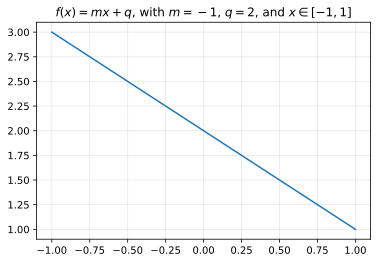

In [9]:
f = Line(-1, 2)  # overwriting previous instance of f with new Class definition
x = 0.5
print('x is {0:.3g} and f(x) is {1:.3g}.'.format(x, f(x)))  # note 'f(x)'
f.draw(start=-1.0, end=1.0)

## The Stochastic Neoclassical Growth Model

Now that we gained basic familiarity with Python objects, we can create our first "economic" object.
We use the Stochastic Neoclassical Growth Model as application.

### Defining the model

We need to collect ideas about how we can code the class.
Given the equations of the model, we can distinguish two applications by using different parameters.
This means that the model needs to be initialized with parameters.
We can then define methods of the model.
In the following example, I do the following:

- `__rouwenhorst`: a routine to discretize AR(1) processes
- `__ergodic_distribution`: a routine to compute the ergodic distribution of a Markov Chain
- `__solve`: a function that performs VFI, given parameters
- `__init__`: instantiates the model with parameters (calibration stage)
- `__call__`: calls `__solve` for a number of gridpoints on the state space and solves the model using VFI (solution stage)
- `plot_deterministic_solution`: after obtaining the solution, plots the policy functions
- `simulate`: simulates the endogenous variables of the model, given policy functions and a time series for the exogenous variable (simulation stage)

As you may be able to tell, the first three methods are not exposed to the final user, meaning we will never directly use those methods (in C/C++ jargon, these are private methods---which are not really private in Python).
The methods `__init__`, `__call__`, `plot_deterministic_solution` and `simulate` are instead supposed to be used directly by the final user.

In [10]:
class GrowthModel:
    
    # Auxiliary functions, workflow below
    
    def __rouwenhorst(self, n):
        def compute_P(p, n):
            if n == 2:
                P = np.array([[p, 1-p], [1-p, p]], dtype=float)
            else:
                Q = compute_P(p, n-1)
                A = np.zeros((n, n))
                B = np.zeros((n, n))
                A[:n-1, :n-1] += Q
                A[1:n, 1:n] += Q
                B[:n-1, 1:n] += Q
                B[1:n, :n-1] += Q
                P = p * A + (1-p) * B
                P[1:-1, :] /= 2
            return P
        p = (1 + self.rho) / 2
        Pi = compute_P(p, n)
        f = np.sqrt(n-1) * (self.sigma / np.sqrt(1 - self.rho**2))
        S = np.linspace(-f, f, n) + self.mu
        return S, Pi
    
    def __ergodic_distribution(self, Pi):
        l, v = la.eig(Pi)
        vector = v[:, np.where(np.isclose(l, 1.))]
        return (vector / np.sum(vector)).reshape((-1,))
    
    def __solve(self, print_sol_info, tolerance=1e-6):
        Nk = self.K.size
        Na = self.s.size
        V0 = np.zeros((Nk, Na))
        V1 = np.zeros_like(V0)
        U = np.zeros_like(V0)
        DRk = np.zeros_like(V0, dtype=int)
        n_iter = 0
        t0 = time()
        while True:
            n_iter += 1
            for i in range(Nk):
                for j in range(Na):
                    C = self.s[j] * self.K[i]**self.alpha + \
                        (1 - self.delta) * self.K[i] - self.K
                    C[C < 0] = np.nan
                    U[:, j] = self.u(C)
                objective = U + self.beta * V0 @ self.Pi.T
                V1[i, :] = np.nanmax(objective, axis=0)
                DRk[i, :] = np.nanargmax(objective, axis=0)
            criterion = np.max(np.max(np.abs(V1 - V0)))
            V0[:] = V1
            if criterion < tolerance:
                break
        t1 = time()
        K1 = self.K[DRk]
        C = np.zeros((Nk, Na))
        for j in range(Na):
            C[:, j] = self.s[j] * self.K**self.alpha + (1 - self.delta) * \
                      self.K - K1[:, j]
        if print_sol_info:
            print('VFI took {} iterations and {:.3g} seconds.'.format(n_iter, t1-t0))
            print('Criterion: sup-norm on successive iterations.')
            print('Criterion = {:.5g} < {:.5g} = Tolerance'.format(criterion, tolerance))
        self.V_opt = V1
        self.K_opt = K1
        self.C_opt = C
        k_ss = np.zeros((Na,))
        for a in range(Na):
            k_ss[a] = self.K[np.abs(self.K - K1[:, a].reshape((-1,))).argmin()]
        self.k_ss = k_ss
        self.y_ss = self.s * self.k_ss ** self.alpha
        self.i_ss = self.delta * self.k_ss  # k_ss - (1 - delta) * k_ss
        self.c_ss = self.y_ss - self.i_ss
    
    # Workflow functions
    
    def __init__(self, alpha, beta, delta, u, mu, sigma, rho):
        self.alpha = alpha  # capital productivity
        self.beta = beta    # discount factor
        self.delta = delta  # capital depreciation
        self.u = u          # utility function
        self.mu = mu        # unconditional avg. of productivity process
        self.sigma = sigma  # st.dev. of productivity innovations
        self.rho = rho      # persistence of productivity process
        self.k_dss = ((1 - (1-self.delta) * self.beta) / (self.alpha * \
                     self.beta)) ** (1 / (self.alpha-1))
        self.y_dss = self.k_dss ** self.alpha
        self.i_dss = self.delta * self.k_dss
        self.c_dss = self.y_dss - self.i_dss
        
        
    def __call__(self, Nk=250, Ns=5, print_sol_info=False):
        s, self.Pi = self.__rouwenhorst(n=Ns)
        self.s = np.exp(s)
        k_lo, k_hi = np.array([0.1, 2.5]) * self.k_dss
        self.K = np.linspace(k_lo, k_hi, num=Nk)
        self.__solve(print_sol_info)
        
    def plot_deterministic_solution(self):
        V_label = r'$V(k, a=1)$'
        C_label = r'$c(k, a=1)$'
        K_label = r"$k'(k, a=1)$"
        Na = self.s.size
        ax = [None] * 3
        pltgrid = (2, 2)
        ax[0] = plt.subplot2grid(pltgrid, (0, 0), rowspan=2)
        ax[1] = plt.subplot2grid(pltgrid, (0, 1))
        ax[2] = plt.subplot2grid(pltgrid, (1, 1))
        ax[0].plot(self.K, self.V_opt[:, Na//2],
                   linewidth=2,
                   color='black',
                   label=V_label)
        ax[1].plot(self.K, self.K_opt[:, Na//2],
                   linewidth=2,
                   color='black',
                   label=K_label,
                   zorder=2)
        ax[2].plot(self.K, self.C_opt[:, Na//2],
                   linewidth=2,
                   color='black',
                   label=C_label)
        ax[1].plot(self.K, self.K,
                   linewidth=1,
                   color='black',
                   linestyle='dashed',
                   zorder=1)
        ax[0].set_title('Value function')
        ax[1].set_title('Capital accumulation decision')
        ax[2].set_title('Consumption decision')
        for a in range(3):
            ax[a].axvline(self.k_dss,
                          color='black',
                          linestyle='dotted',
                          zorder=1)
            ax[a].grid(alpha=0.3)
            ax[a].set_xlabel('$k$')
            ax[a].legend()
        plt.tight_layout()

    def simulate(self, shock_series=None, initial_condition=None):
        K_fun = ip.interp2d(self.K, self.s, self.K_opt.T, kind='cubic')
        t = shock_series.size
        c_sim = np.zeros((t,))
        k_sim = np.zeros((t,))
        i_sim = np.zeros((t,)) 
        y_sim = np.zeros((t,))
        if initial_condition is None:
            c_sim[0] = self.c_dss
            k_sim[0] = self.k_dss
            i_sim[0] = self.i_dss
            y_sim[0] = self.y_dss
        else:
            c_sim[0] = initial_condition['c']
            k_sim[0] = initial_condition['k']
            i_sim[0] = initial_condition['i']
            y_sim[0] = initial_condition['y']
        for h in range(t-1):
            k_sim[h+1] = K_fun(k_sim[h], shock_series[h])
        for h in range(1, t-1):
            y_sim[h] = shock_series[h] * k_sim[h] ** self.alpha
            i_sim[h] = k_sim[h+1] - (1 - self.delta) * k_sim[h]
            c_sim[h] = y_sim[h] - i_sim[h]
        y_sim[-1] = shock_series[-1] * k_sim[-1] ** self.alpha
        i_sim[-1] = np.nan
        c_sim[-1] = np.nan
        return {'capital':     k_sim,
                'production':  y_sim,
                'consumption': c_sim,
                'investment':  i_sim}

This example is missing one important feature: _input validation_.
As you may realize, we made assumptions about input arguments.
If those assumptions were not satisfied, then it would be very difficult to go spot the problem.
An example of input validation may be the following:

```python
def __solve(self, K, A, tolerance):
    if K.ndim > 1:
        raise ValueError('Grid for capital must have one dimension.')
    if A.ndim > 1:
        raise ValueError('Grid for productivity must have one dimesion.')
```

Or, otherwise:

```python
def __init__(self, alpha, beta, delta, u, mu, sigma, rho, ns, print_sol_info=False):
    if not 0 < beta < 1:
        raise ValueError('Beta should be between 0 and 1 (excluded).')
    if not abs(rho) < 1:
        raise ValueError('Productivity process should not be a unit root.')
```

### Using the model

Now that we defined the object, we are simply left with using it!
First, we parametrize the model.

In [11]:
a = 0.3   # alpha
b = 0.95  # beta
g = 1.5   # gamma
d = 0.1   # delta
m = 0     # mu
s = 0.1   # sigma
r = 0.8   # rho
na = 9    # no. of gridpoints for productivity
nk = 750  # no. of gridpoints for capital

def u(c, gamma):  # CRRA utility function
    return c ** (1-gamma) / (1-gamma)

mdl = GrowthModel(a, b, d, lambda c: u(c, g), m, s, r)

Next, we "call" the model in order to solve it.

In [12]:
mdl(nk, na, print_sol_info=True)

VFI took 285 iterations and 151 seconds.
Criterion: sup-norm on successive iterations.
Criterion = 9.5092e-07 < 1e-06 = Tolerance


Now we plot the policy functions at the deterministic steady state (i.e., productivity equals one forever).

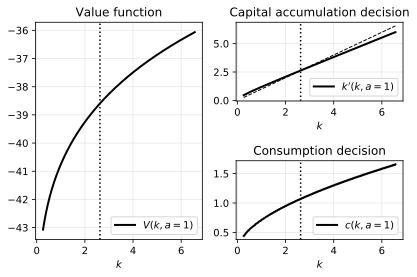

In [13]:
mdl.plot_deterministic_solution()

Finally, we can simulate the model.
For this, we generate a random AR(1) process as our synthetic productivity process.
Note that the parameters that characterize the synthetic simulation _must_ be the same as the parameters we used to parametrize the model, as the solution depends on those numeric values.

In [14]:
def sim_ar1(t, mu, rho, sigma):
    """
    Creates 200 extra observations as 'burn-in' to remove
    reliance on initial condition.
    """
    y = np.zeros((t+200,))
    y[0] = mu
    for j in range(1, y.size):
        eps = np.random.normal()
        y[j] = (1 - rho) * mu + rho * y[j-1] + sigma * eps
    return y[-t:]

T = 40
productivities = np.exp(sim_ar1(T, m, r, s))
simulation = mdl.simulate(shock_series=productivities)

Now we can plot the solutions.

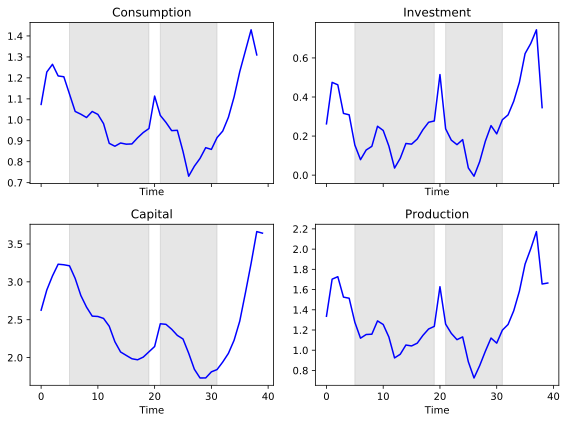

In [15]:
colorstate = ['firebrick', 'green']
lows = productivities < 1
low_in = [i for i in range(1, T) if (lows[i-1] == False and lows[i] == True)]
low_out = [i for i in range(T-1) if (lows[i] == True and lows[i+1] == False)]
if lows[0] == True:
    low_in.insert(0, 0)
if lows[T-1] == True:
    low_out.append(T-1)

prop_sims = {'color':     'blue',
             'linewidth': 1.5,
             'zorder':    3,
             'label':     'Sample path'}

prop_ss_lo = {'color':     colorstate[0],
              'linewidth': 1,
              'linestyle': 'dashed',
              'zorder':    2,
              'label':     'Low steady state'}

prop_ss_hi = {'color':     colorstate[1],
              'linewidth': 1,
              'linestyle': 'dashed',
              'zorder':    2,
              'label':     'High steady state'}

fig1, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False,
                         figsize=(8, 6))

ax1[0, 0].plot(simulation['consumption'], **prop_sims)
ax1[0, 1].plot(simulation['investment'],  **prop_sims)
ax1[1, 0].plot(simulation['capital'],     **prop_sims)
ax1[1, 1].plot(simulation['production'],  **prop_sims)

for i in range(2):
    for j in range(2):
        ax1[i, j].set_xlabel('Time')
        for a, b in zip(low_in, low_out):
            ax1[i, j].axvspan(a, b, color='black', alpha=0.1, zorder=1)

ax1[0, 0].set_title('Consumption')
ax1[0, 1].set_title('Investment')
ax1[1, 0].set_title('Capital')
ax1[1, 1].set_title('Production')

plt.tight_layout()

Finally, we can put our simulations in a [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html)' [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) and compute summary statistics.
Ideally, we would compare these summary statistics to real data, so to assess the adequacy of the model in generating whatever moment in the data we might be interested in.

In [16]:
pd.DataFrame(simulation).describe()

,capital,production,consumption,investment
count,40.000000,40.000000,39.000000,39.000000
mean,2.456240,1.288362,1.016894,0.261821
std,0.525738,0.321057,0.162245,0.173952
min,1.730922,0.725430,0.730908,-0.005479
25%,2.049116,1.095814,0.888512,0.155208
50%,2.394305,1.204364,0.987424,0.232618
75%,2.828624,1.516944,1.111024,0.312439
max,3.663530,2.173360,1.429308,0.744051
